# Game Sales

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

## 1 分析の目的

世界のゲームの販売データから地域別の販売傾向を分析します。

![](images/video-game-sales-screenshot.png)

データは Kaggle Dataset [Video Game Sales](https://www.kaggle.com/gregorut/videogamesales) から入手したものを本講座用に加工したものを使います。

## 2 データ

集計対象は、1980年から2016年10月までの世界のゲームの販売データです。データは以下の二つのファイルに分割されています。

- `game_sales.csv`: ゲームタイトルの販売数を地域別に記録したデータ
- `game_info.csv`: ゲームタイトルの情報を記録したデータ

## 3 データの読み込みと確認

### データの読み込み 

`data/game_sales.csv` を `DataFrame` として読み込んで `game_sales` と名付けて下さい。`game_sales.csv` に記録されているデータは16598行、6列で、各行は

- `ID`: ゲームタイトルのID
- `NA_Sales`: 北米での販売数
- `EU_Sales`: 欧州での販売数
- `JP_Sales`: 日本での販売数
- `Other_Sales`: その他地域での販売数
- `Global_Sales`: 全世界での販売数

となっています。販売数の単位は100万本です。

In [3]:
# data/game_sales.csv を DataFrame として読み込んで game_sales と名付けて下さい。
game_sales = pd.read_csv('data/game_sales.csv', index_col=0)

In [4]:
game_sales.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
ID                                                            
18690      0.09      0.18      0.01         0.10          0.37
16381      0.11      0.15      0.00         0.06          0.32
7473       0.00      0.00      0.02         0.00          0.02
12972      0.41      0.11      0.00         0.04          0.55
4354       0.01      0.00      0.00         0.00          0.01

### データの確認

データの行数と列数が正しいかどうかを確認します。

In [5]:
# game_sales の行数と列数が正しいことを確認してください。
game_sales.shape

(16598, 5)

各列のデータ型を確認します。データ型を変換する必要があるのかどうかを確認します。

In [6]:
# 各列のデータ型を確認してください。
game_sales.dtypes

NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object

データの要約統計量を確認します。確認するべき点は

- データの欠損
- 外れ値
- 矛盾のある数値

In [7]:
# データの要約統計量を確認してください。
game_sales.describe()

NA_Sales      EU_Sales      JP_Sales   Other_Sales  Global_Sales
count  16598.000000  16598.000000  16593.000000  16598.000000  16583.000000
mean       0.264667      0.146652      0.077638      0.048063      0.537739
std        0.816683      0.505351      0.309496      0.188588      1.555655
min        0.000000      0.000000     -0.500000      0.000000      0.010000
25%        0.000000      0.000000      0.000000      0.000000      0.060000
50%        0.080000      0.020000      0.000000      0.010000      0.170000
75%        0.240000      0.110000      0.040000      0.040000      0.470000
max       41.490000     29.020000     10.220000     10.570000     82.740000

外れ値や欠損が確認できた場合は、それぞれのパターンを確認するため実際にレコードを確認します。

`JP_Sales` の最小値が -0.5 であることに気が付きます。`JP_Sales` の値が 0 以下であるレコードを確認します。

In [8]:
# 外れ値や欠損のあるレコードを確認してください。
game_sales.query('JP_Sales < 0')

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
ID                                                            
15893      0.00      0.08      -0.5         0.01           NaN
5164       0.03      0.01      -0.5         0.00           NaN
5126       0.09      0.00      -0.5         0.01           NaN
13629      0.00      0.00      -0.5         0.00           NaN
13893      0.01      0.00      -0.5         0.00           NaN

`JP_Sales` の値が -0.5 以下であるレコードが存在するだけでなく、`Global_Sales` に欠損があるレコードが存在することが確認できます。他にも欠損を含むレコードが存在しているかもしれません。これを確認します。

In [9]:
# 一つでも NaN を含む行を選択してください。
game_sales[game_sales.isnull().any(axis=1)]

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
ID                                                            
1738       0.00      0.00       NaN         0.00           NaN
239        0.10      0.08      0.00         0.03           NaN
10421      0.20      0.08      0.00         0.01           NaN
15893      0.00      0.08     -0.50         0.01           NaN
8960       1.52      0.10      0.00         0.02           NaN
13236      0.00      0.00      0.01         0.00           NaN
6793       0.10      0.04      0.00         0.00           NaN
2450       0.00      0.00       NaN         0.00           NaN
9700       0.02      0.02       NaN         0.01           NaN
5550       0.12      0.00       NaN         0.01           NaN
7032       0.00      0.15       NaN         0.01           NaN
5164       0.03      0.01     -0.50         0.00           NaN
5126       0.09      0.00     -0.50         0.01           NaN
13629      0.00      0.00     -0.50         0.00           NaN
13893      0.01      0.00     -0.50         0.00           NaN

`Global_Sales` だけでなく `JP_Sales` にも欠損があるレコードがあることが確認できました。

### 外れ値や欠損データの処理

`JP_Sales` の不正値と欠損は修正しようがありませんので負値と欠損を含むレコードは削除しなければなりません。しかし、`Global_Sales` だけが欠損しているレコードは、その他の地域の販売数の総和を `Global_Sales` に代入することで修正できます。

まず、`JP_Sales` に負値と欠損を含むレコードを削除します。結果を `tmp_1` に格納します。

In [10]:
tmp_1 = game_sales.query('JP_Sales >= 0')

結果を確認します。

In [11]:
tmp_1[tmp_1.isnull().any(axis=1)]

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
ID                                                            
239        0.10      0.08      0.00         0.03           NaN
10421      0.20      0.08      0.00         0.01           NaN
8960       1.52      0.10      0.00         0.02           NaN
13236      0.00      0.00      0.01         0.00           NaN
6793       0.10      0.04      0.00         0.00           NaN

正しく修正されました。つぎに、`Global_Sales` の欠損をその他での地域の販売数の総和で修正します。結果を `tmp_2` に格納します。

In [12]:
tmp_2 = tmp_1.fillna({
    'Global_Sales': tmp_1[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum(axis=1)
})

結果を確認します。

In [13]:
tmp_2[tmp_2.isnull().any(axis=1)]

Empty DataFrame
Columns: [NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales]
Index: []

正しく修正されました。`tmp_2` を `game_sales` に格納します。

In [14]:
game_sales = tmp_2

### 演習問題

`data/game_info.csv` を `DataFrame` として読み込んで `game_info` という変数にしてください。`game_info.csv` に記録されているデータは16598行、6列で、各行は

- `ID`: ゲームタイトルのID
- `Rank`: 販売数での順位
- `Name`: 名前
- `Year`: 発売年
- `Platform`: プラットフォーム (PS4、Wii等)
- `Genre`: ジャンル
- `Publisher`: 販売会社

となっています。

#### データの読み込み

In [15]:
# data/game_sales.csv を DataFrame として読み込んで game_info と名付けて下さい。
game_info = pd.read_csv('data/game_info.csv', index_col=0)

In [16]:
game_info.head()

Rank                      Name Platform    Year         Genre Publisher
ID                                                                            
4833      1                Wii Sports      Wii  2006.0        Sports  Nintendo
8443      2         Super Mario Bros.      NES  1985.0      Platform  Nintendo
17315     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo
15726     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo
17712     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo

#### データの確認

In [17]:
# game_info の行数と列数を確認してください。
game_info.shape

(16598, 6)

In [18]:
# 各列のデータ型を確認してください。
#
# Hint: int であるはずの列のデータ型が float と表示された場合は、その列は NaN を含む。
game_info.dtypes

Rank           int64
Name          object
Platform      object
Year         float64
Genre         object
Publisher     object
dtype: object

In [19]:
# データの要約統計量を確認してください。
game_info.describe()

Rank          Year
count  16598.000000  16327.000000
mean    8300.605254   2006.406443
std     4791.853933      5.828981
min        1.000000   1980.000000
25%     4151.250000   2003.000000
50%     8300.500000   2007.000000
75%    12449.750000   2010.000000
max    16600.000000   2020.000000

In [20]:
game_info.describe(include=['O'])

Name Platform   Genre        Publisher
count                         16598    16598   16598            16540
unique                        11493       31      12              578
top     Need for Speed: Most Wanted       DS  Action  Electronic Arts
freq                             12     2163    3316             1351

各列のデータ型を確認した際に `int` であるはずの `Year` のデータ型が `float` と表示されていた。これは `Year` に `NaN` が含まれているレコードが存在することを示す。欠損の含むレコードを確認する。

In [21]:
# 外れ値や欠損のある場合はレコードを確認してください。
game_info[game_info.isnull().any(axis=1)]

Rank                                               Name Platform  \
ID                                                                         
10056    180                                    Madden NFL 2004      PS2   
4491     378                                   FIFA Soccer 2004      PS2   
11395    432                         LEGO Batman: The Videogame      Wii   
4842     471                         wwe Smackdown vs. Raw 2006      PS2   
5864     608                                     Space Invaders     2600   
4049     625                                          Rock Band     X360   
8684     650           Frogger's Adventures: Temple of the Frog      GBA   
16289    653        LEGO Indiana Jones: The Original Adventures      Wii   
6042     713                                     Call of Duty 3      Wii   
18507    784                                          Rock Band      Wii   
17855   1128                            Call of Duty: Black Ops       PC   
19771   1135                                          Rock Band      PS3   
14370   1305                                     Triple Play 99       PS   
12982   1435                       LEGO Harry Potter: Years 5-7      Wii   
11133   1500                         LEGO Batman: The Videogame      PSP   
17357   1515                                          Adventure     2600   
18591   1587                                             Combat     2600   
4174    1651                                NASCAR Thunder 2003      PS2   
3459    1664       Shrek / Shrek 2 2-in-1 Gameboy Advance Video      GBA   
7705    1699                          Hitman 2: Silent Assassin       XB   
9685    1839                                          Rock Band      PS2   
19818   1992                        Legacy of Kain: Soul Reaver       PS   
10824   2021                               Donkey Kong Land III       GB   
8780    2088                       LEGO Harry Potter: Years 5-7     X360   
12882   2115                                     Air-Sea Battle     2600   
344     2116                                       Suikoden III      PS2   
17061   2136                                           Yakuza 4      PS3   
14254   2147                       LEGO Harry Potter: Years 5-7      PS3   
394     2175                                   Wheel of Fortune      PS2   
18077   2224                                 Bentley's Hackpack      GBA   
...      ...                                                ...      ...   
19388  15609         Writing and Speaking Beautiful Japanese DS       DS   
3443   15655                                       Virtua Quest      PS2   
7532   15700            Shonen Jump's Yu-Gi-Oh! GX Card Almanac       DS   
11508  15720                                    Without Warning       XB   
13963  15742                              Football Manager 2007     X360   
18590  15791  Moshi, Kono Sekai ni Kami-sama ga Iru to suru ...      PSV   
17164  15814                       Ferrari: The Race Experience      Wii   
592    15868                  PDC World Championship Darts 2008       DS   
3179   15879                    Dinotopia: The Sunstone Odyssey       GC   
12098  15881                             Dance! It's Your Stage      Wii   
2976   15903                                        Jet Impulse       DS   
7662   15918                                       Dream Dancer       DS   
6889   16060                  PDC World Championship Darts 2008      PSP   
7909   16061                  WRC: FIA World Rally Championship       PC   
1917   16068                       Aquaman: Battle for Atlantis       XB   
12634  16194                    Homeworld Remastered Collection       PC   
11142  16197                                             Shorts       DS   
16026  16201             AKB1/48: Idol to Guam de Koishitara...     X360   
13295  16211  Super Robot Monkey Team: Game Boy Advance Vide...      GBA   
8297   16232                        Brothers in Arms: Fu

`Year` に欠損の存在するレコードがあるだけでなく `Publisher` にも欠損を含むレコードが存在することが確認できる。

#### 外れ値や欠損データの処理

欠損を含むレコードを削除します。

In [22]:
# 外れ値や欠損のある場合はそれらを含むレコードを処理してください。
game_info = game_info.dropna()

さらに、`Year` のデータ型を `int` に変換します。

In [23]:
game_info['Year'] = game_info['Year'].astype(int)
game_info.dtypes

Rank          int64
Name         object
Platform     object
Year          int64
Genre        object
Publisher    object
dtype: object

## 4 データ加工と基礎集計

### データのマージ

集計に必要な情報が二つのテーブル（`game_sales` と `game_info`）に分離しているため一つにまとめます。この作業をマージと呼びます。確認すべき点は

- マージ前後での件数の変化と
- マージ後の欠損データの有無

です。

In [24]:
# game_sales と game_info をマージして game_data と名付けてください。
game_data = pd.concat([game_sales, game_info], axis=1, join='inner')

今回は2001年から2015年までの期間を対象にするので、この期間外のデータを削除します。

In [25]:
game_data.query('Year > 2000 & Year < 2016', inplace=True)
game_data.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales   Rank  \
ID                                                                      
18690      0.09      0.18      0.01         0.10          0.37   5113   
16381      0.11      0.15      0.00         0.06          0.32   5603   
7473       0.00      0.00      0.02         0.00          0.02  15860   
12972      0.41      0.11      0.00         0.04          0.55   3632   
4354       0.01      0.00      0.00         0.00          0.01  16587   

                                          Name Platform  Year       Genre  \
ID                                                                          
18690    Prince of Persia: The Forgotten Sands      PSP  2010      Action   
16381                              Overlord II      PS3  2009      Action   
7473         Kadenz fermata//Akkord:fortissimo      PSV  2014   Adventure   
12972  ZhuZhu Pets 2: Featuring The Wild Bunch       DS  2010  Simulation   
4354                          Bust-A-Move 3000       GC  2003      Puzzle   

         Publisher  
ID                  
18690      Ubisoft  
16381  Codemasters  
7473           5pb  
12972   Activision  
4354       Ubisoft

In [26]:
# game_data の行数と列数を確認してください。
game_data.shape

(13613, 11)

In [27]:
# game_data の各列のデータ型を確認してください。
game_data.dtypes

NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
Rank              int64
Name             object
Platform         object
Year              int64
Genre            object
Publisher        object
dtype: object

In [28]:
# game_data の要約統計量を確認してください。
game_data.describe()

NA_Sales      EU_Sales      JP_Sales   Other_Sales  Global_Sales  \
count  13613.000000  13613.000000  13613.000000  13613.000000  13613.000000   
mean       0.249628      0.147868      0.055293      0.052518      0.505617   
std        0.730933      0.525472      0.249835      0.205090      1.501231   
min        0.000000      0.000000      0.000000      0.000000      0.010000   
25%        0.000000      0.000000      0.000000      0.000000      0.060000   
50%        0.080000      0.020000      0.000000      0.010000      0.160000   
75%        0.230000      0.110000      0.030000      0.040000      0.450000   
max       41.490000     29.020000      6.500000     10.570000     82.740000   

               Rank          Year  
count  13613.000000  13613.000000  
mean    8503.209946   2007.944906  
std     4781.767702      3.736084  
min        1.000000   2001.000000  
25%     4359.000000   2005.000000  
50%     8603.000000   2008.000000  
75%    12662.000000   2011.000000  
max    16600.000000   2015.000000

In [29]:
game_data.describe(include=['O'])

Name Platform   Genre        Publisher
count                         13613    13613   13613            13613
unique                         9105       20      12              434
top     Need for Speed: Most Wanted       DS  Action  Electronic Arts
freq                             12     2128    2857             1180

### 各列の分布の確認

分布の集計と可視化の方法は、データ型によって異なります。

| データ型 |       集計      |       可視化      |
|:--------:|:---------------:|:-----------------:|
|   数値   |  四分位数、分散  |    ヒストグラム   |
| カテゴリ | ユニーク数、分布 | 棒グラフ、円グラフ |

数値データの分布を確認します。全世界での売上本数の四分位数と分散を確認します。

In [30]:
# 全世界での売上数の要約統計量を確認してください。
game_data[['Global_Sales']].describe()

Global_Sales
count  13613.000000
mean       0.505617
std        1.501231
min        0.010000
25%        0.060000
50%        0.160000
75%        0.450000
max       82.740000

全世界での売上本数の分布をヒストグラムから確認します。

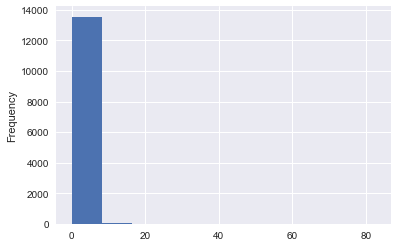

In [31]:
# 全世界での売上数のヒストグラムをプロットしてください。
game_data['Global_Sales'].plot.hist()

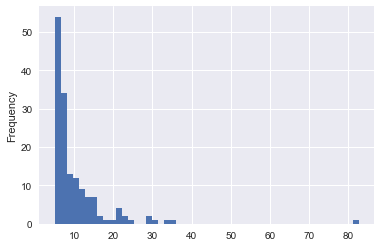

In [32]:
game_data.query('Global_Sales > 5')['Global_Sales'].plot.hist(bins=50)

カテゴリデータの分布を確認します。ゲームの発売年の数と各年に発売されたゲームの分布数を確認します。

In [33]:
# ゲームの発売年の数を確認してください。
game_data['Year'].unique().size

15

In [34]:
# 各年に発売されたゲームタイトル数の分布を確認してください。
titles_by_year = game_data['Year'].value_counts().sort_index()

各年に発売されたゲームの分布を棒グラフで確認します。

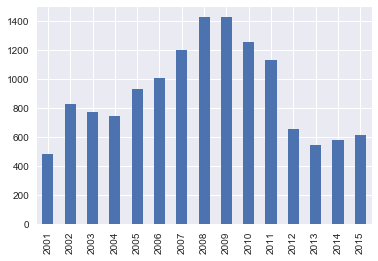

In [35]:
# 各年に発売されたゲームタイトル数を棒グラフとしてプロットしてください。
titles_by_year.plot.bar()

### 練習問題

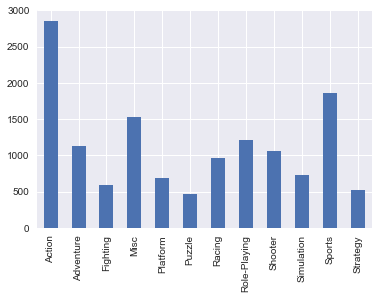

In [36]:
# ジャンルごとのゲームタイトルの数を棒グラフにして可視化して下さい。
(game_data['Genre']
 .value_counts()
 .sort_index()
 .plot.bar())

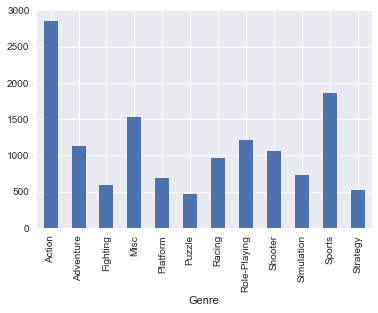

In [37]:
game_data.groupby('Genre')['Global_Sales'].count().plot.bar()

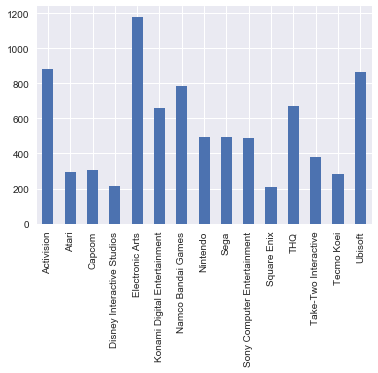

In [38]:
# ゲームタイトル数がトップ15の販売会社のゲームタイトル数を棒グラフでプロットしてください。
(game_data['Publisher']
 .value_counts()[:15]
 .sort_index()
 .plot.bar())

## 5 可視化

- 今回の分析の目的は、地域別の売上傾向を分析すること
- 全体の傾向と地域別の傾向を比較して知見を得る

### 集計対象の整理

アウトプットをイメージして集計対象を整理します。

|        集計項目        |            利用する要素            |    可視化    |
|:----------------------:|:----------------------------------:|:------------:|
|    地域別の販売割合    |           各地域の販売数           |   円グラフ   |
|      年別の販売数      |        各地域の年別の販売数        | 線、面グラフ |
|   ジャンル別の販売数   |     各地域のジャンル別の販売数     |   棒グラフ   |
| プラットフォーム別の販売数 | 各地域のプラットフォーム別の販売数 |   棒グラフ   |

### クロス集計と可視化

これから先の集計で地域別販売数の列名のリスト `['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']` が何度も必要になります。このリストを `SALES` と名付けます。

In [39]:
SALES = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

#### 地域別の販売シェア

各地域の販売シェアを集計して可視化します。

In [40]:
# 地域別販売数を集計してください。
# 結果を昇順に並べ替えて sales_by_region と名付けてください。
sales_by_region = game_data[SALES].sum().sort_values()

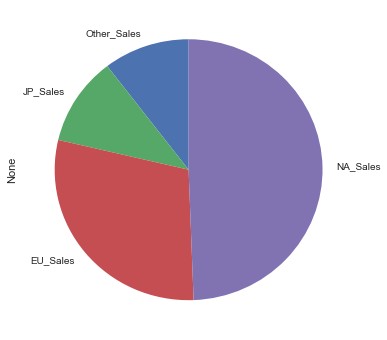

In [41]:
# sales_by_region を円グラフにプロットしてください。
fig, ax = plt.subplots(figsize=(6, 6))
sales_by_region.plot.pie(startangle=90, ax=ax)

グラフから読み取れることはなんですか？

- 販売数の約50%は北米、日本は全世界の10%程度である。

#### 地域別の販売数およびシェアの推移

地域別販売数の推移を集計して可視化します。

In [42]:
# 発売年ごとの地域別販売数を集計してください。結果を sales_by_year と名付けてください。
sales_by_year = game_data.groupby('Year')[SALES].sum()
sales_by_year.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Year                                           
2001    173.98     94.89     39.86        22.76
2002    216.18    109.74     41.76        27.28
2003    193.59    103.81     34.20        26.01
2004    218.80    105.92     41.65        47.24
2005    241.53    121.53     54.28        40.54

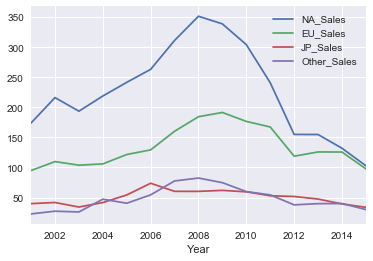

In [43]:
# sales_by_year をX軸に発売年、Y軸に販売数を地域別の線グラフとしてプロットしてください。
sales_by_year.plot()

地域別の販売数のシェアの推移を集計して可視化します。

In [44]:
# sales_by_year の各年の地域ごとの販売数をそれらの総和で割ってください。
# 結果を share_by_year と名付けてください。
share_by_year = sales_by_year.apply(lambda x : x / sales_by_year.sum(axis=1))
share_by_year.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Year                                           
2001  0.524842  0.286253  0.120245     0.068660
2002  0.547347  0.277851  0.105732     0.069070
2003  0.541344  0.290288  0.095635     0.072733
2004  0.529001  0.256087  0.100699     0.114214
2005  0.527496  0.265419  0.118546     0.088538

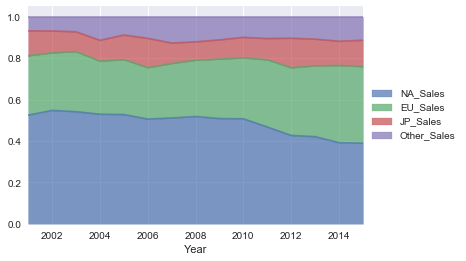

In [45]:
# share_by_year を面グラフとしてプロットして下さい。
#
# Hint: 面グラフは、DataFrame.plot.area() でプロットすることができます。
fig, ax = plt.subplots()
share_by_year.plot.area(alpha=0.7, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

グラフから読み取れることはなんですか？

- 世界では2008年をピークに販売数は減少している。日本では2006年ごろにピークがある。
- 近年では北米とヨーロッパで販売数に差がなくなってきている。

#### 各地域でのジャンル別の販売数および販売シェア

ジャンル別の販売数を地域別に集計して可視化します。

In [46]:
# ジャンルごとに地域別販売数を集計してください。結果を sales_by_genre と名付けてください。
sales_by_genre = game_data.groupby('Genre')[SALES].sum()
sales_by_genre.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Genre                                               
Action       727.08    454.86    121.21       174.33
Adventure     81.20     48.96     35.03        14.84
Fighting     149.72     68.05     41.07        30.38
Misc         355.27    192.88     81.50        71.00
Platform     250.44    135.75     52.54        40.81

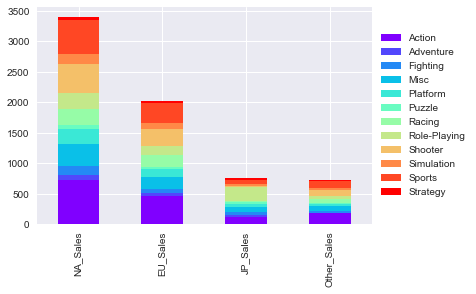

In [47]:
# sales_by_genre を、X軸に地域、Y軸にジャンル別の販売数を
# 積み上げ棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(sales_by_genre
 .transpose()
 .plot.bar(stacked=True, cmap='rainbow', ax=ax))
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

ジャンル別の販売数のシェアを地域別に集計して可視化します。

In [48]:
# sales_by_genre の各ジャンルの販売数をそれらの総和で割ってください。
# 結果を share_by_genre と名付けてください。
share_by_genre = sales_by_genre.apply(lambda x : x / sales_by_genre.sum(), axis=1)
share_by_genre.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Genre                                               
Action     0.213961  0.225969  0.161034     0.243842
Adventure  0.023895  0.024323  0.046539     0.020757
Fighting   0.044059  0.033806  0.054564     0.042494
Misc       0.104547  0.095821  0.108277     0.099310
Platform   0.073698  0.067439  0.069802     0.057083

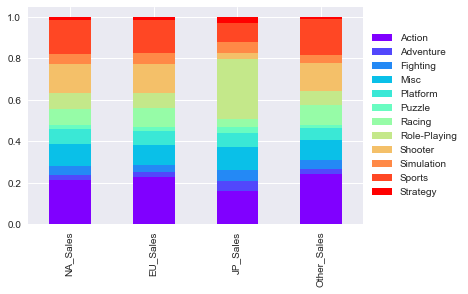

In [49]:
# share_by_genre をX軸に地域、Y軸にジャンル別の販売シャアの
# 積み上げ棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(share_by_genre
 .transpose()
 .plot.bar(stacked=True, cmap='rainbow', ax=ax))
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

グラフから読み取れることはなんですか？

- 全体では、Action や Sports の販売数が多い。
- 日本のみ RPG の割合が高い。
- 日本以外の地域間では分布にあまり差がない。

#### 各地域でのプラットフォーム別の販売数および販売シェア

プラットフォーム別の販売数を地域別に集計して可視化します。

In [50]:
# プラットフォームごとに地域別販売数を集計してください。
# 結果を sales_by_platform と名付けてください。
sales_by_platform = game_data.groupby('Platform')[SALES].sum()
sales_by_platform.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Platform                                           
3DS          77.20     57.72     92.20        12.43
DC            0.00      0.00      1.42         0.00
DS          388.26    193.90    175.00        60.26
GB            2.73      1.67      4.65         0.19
GBA         178.34     72.46     46.56         7.51

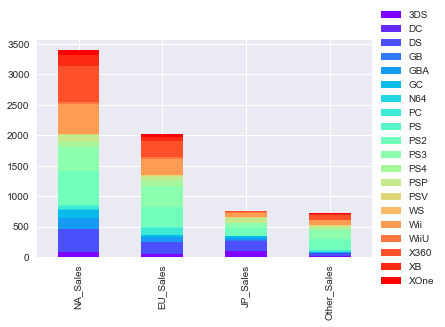

In [51]:
# sales_by_platform を、X軸に地域、Y軸にプラットフォーム別の販売数を
# 積み上げ棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(sales_by_platform
 .transpose()
 .plot.bar(stacked=True, cmap='rainbow', ax=ax))
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

プラットフォーム別の販売数のシェアを地域別に集計して可視化します。

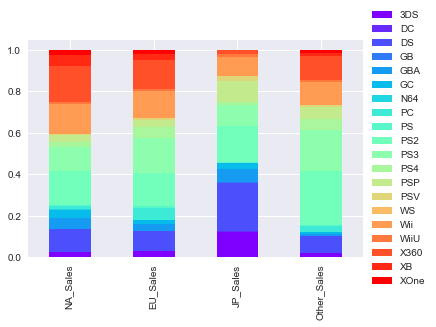

In [52]:
# sales_by_platform のプラットフォーム別の販売数をそれらの総和で割ってください。
# 結果を積み上げ棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(sales_by_platform
 .apply(lambda x : x / sales_by_platform.sum(axis=0), axis=1)
 .transpose()
 .plot.bar(stacked=True, cmap='rainbow', ax=ax))
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

グラフから読み取れることはなんですか？

- 全体では DS 系、Xbox 系、PS 系の販売数が多い
- 日本では DS 系の割合が大きく、Xbox 系の割合が小さい
- 北米では Xbox 系の割合が大きい

#### 各地域での販売数トップ15のゲームタイトル

全世界での販売数がトップ15のゲームタイトルの地域別販売数を抽出して可視化します。

In [53]:
# game_data から全世界での販売数が上位15のゲームタイトルの
# 地域別販売数を抽出してください。結果を top15_global と名付けてください。
top15_global = (game_data
         .sort_values('Global_Sales', ascending=False)
         .head(15)[['Name'] + SALES]
         .set_index('Name'))
top15_global.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Name                                                            
Wii Sports                41.49     29.02      3.77         8.46
Mario Kart Wii            15.85     12.88      3.79         3.31
Wii Sports Resort         15.75     11.01      3.28         2.96
New Super Mario Bros.     11.38      9.23      6.50         2.90
Wii Play                  14.03      9.20      2.93         2.85

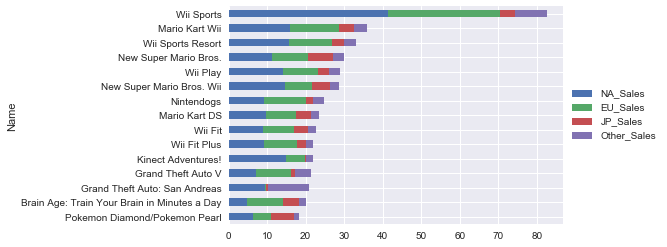

In [54]:
# top15_global をX軸がゲームタイトル、Y軸が地域別販売数の
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
top15_global.plot.barh(stacked=True, ax=ax)
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

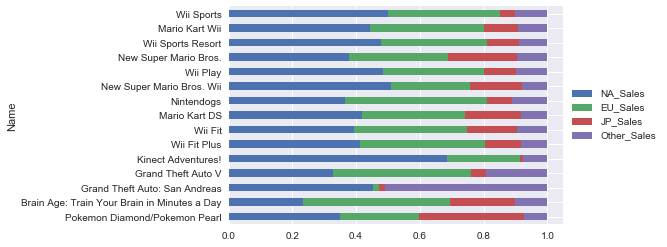

In [55]:
# top15_global をX軸がゲームタイトル、Y軸が地域別販売シェアの
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(top15_global
 .apply(lambda x : x / top15_global.sum(axis=1))
 .plot.barh(stacked=True, ax=ax))
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

グラフから読み取れることはなんですか？

- Wiiに関連するタイトルが上位を占めている。
- 北米と欧州での販売数が多いタイトルが多い。

北米での販売数が上位15のゲームタイトルの地域別販売数を抽出して可視化します。

In [56]:
# game_data から北米での販売数が上位15のゲームタイトルの
# 地域別販売数を抽出してください。結果を top15_na と名付けてください。
top15_na = (game_data
         .sort_values('NA_Sales', ascending=False)
         .head(15)[['Name'] + SALES]
         .set_index('Name'))
top15_na.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Name                                                                
Wii Sports                    41.49     29.02      3.77         8.46
Mario Kart Wii                15.85     12.88      3.79         3.31
Wii Sports Resort             15.75     11.01      3.28         2.96
Kinect Adventures!            14.97      4.94      0.24         1.67
New Super Mario Bros. Wii     14.59      7.06      4.70         2.26

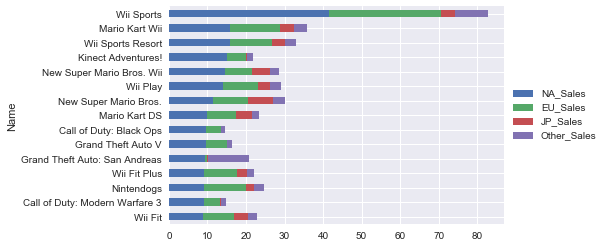

In [57]:
# top15_na をX軸がゲームタイトル、Y軸が地域別販売数の
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
top15_na.plot.barh(stacked=True, ax=ax)
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

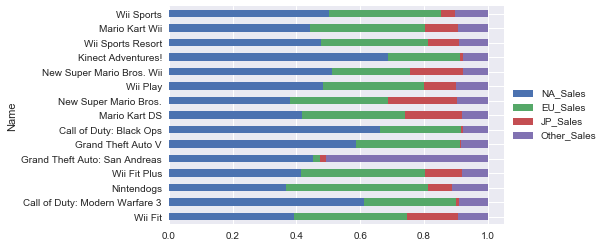

In [58]:
# top15_na をX軸がゲームタイトル、Y軸が地域別販売シェアの
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(top15_na
 .apply(lambda x : x / top15_na.sum(axis=1))
 .plot.barh(stacked=True, ax=ax))
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

グラフから読み取れることはなんですか？

- Wiiに関連するタイトルが上位を占めている。
- Wii以外では日本でほとんど売れていないタイトルが売れている。

欧州での販売数がトップ15のゲームタイトルの地域別販売数を抽出して可視化します。

In [59]:
# game_data から欧州での販売数が上位15のゲームタイトルの
# 地域別販売数を抽出してください。結果を top15_eu と名付けてください。
top15_eu = (game_data
         .sort_values('EU_Sales', ascending=False)
         .head(15)[['Name'] + SALES]
         .set_index('Name'))
top15_eu.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Name                                                         
Wii Sports             41.49     29.02      3.77         8.46
Mario Kart Wii         15.85     12.88      3.79         3.31
Wii Sports Resort      15.75     11.01      3.28         2.96
Nintendogs              9.07     11.00      1.93         2.75
Grand Theft Auto V      7.01      9.27      0.97         4.14

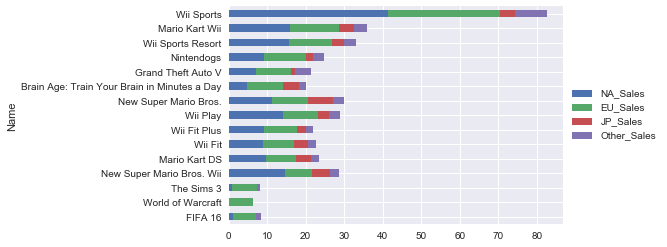

In [60]:
# top15_eu をX軸がゲームタイトル、Y軸が地域別販売数の
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
top15_eu.plot.barh(stacked=True, ax=ax)
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

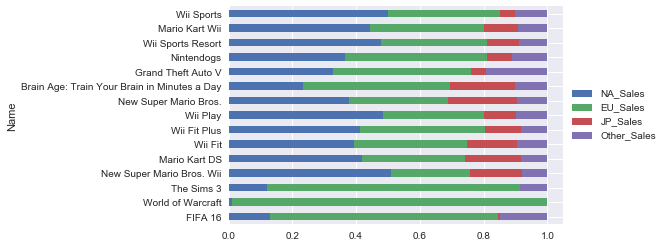

In [61]:
# top15_eu をX軸がゲームタイトル、Y軸が地域別販売シェアの
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(top15_eu
 .apply(lambda x : x / top15_eu.sum(axis=1))
 .plot.barh(stacked=True, ax=ax))
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

グラフから読み取れることはなんですか？

- Wii に関連するタイトルが上位を占めている。
- Wii に関連しないタイトルは日本でほとんど売れていないタイトルが売れている。

日本での販売数が上位15のゲームタイトルの地域別販売数を抽出して可視化します。

In [62]:
# game_data から日本での販売数が上位15のゲームタイトルの
# 地域別販売数を抽出してください。結果を top15_jp と名付けてください。
top15_jp = (game_data
         .sort_values('JP_Sales', ascending=False)
         .head(15)[['Name'] + ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
         .set_index('Name'))
top15_jp.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Name                                                                    
New Super Mario Bros.             11.38      9.23      6.50         2.90
Pokemon Diamond/Pokemon Pearl      6.42      4.52      6.04         1.37
Pokemon Black/Pokemon White        5.57      3.28      5.65         0.82
Pokemon Ruby/Pokemon Sapphire      6.06      3.90      5.38         0.50
Animal Crossing: Wild World        2.55      3.52      5.33         0.88

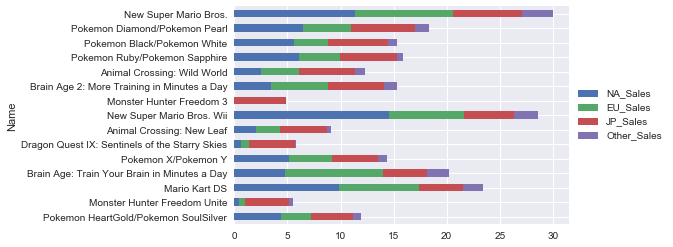

In [63]:
# top15_jp をX軸がゲームタイトル、Y軸が地域別販売数の
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
top15_jp.plot.barh(stacked=True, ax=ax)
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

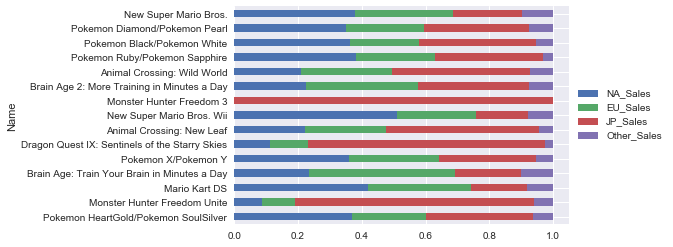

In [64]:
# top15_jp をX軸がゲームタイトル、Y軸が地域別販売シェアの
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(top15_jp
 .apply(lambda x : x / top15_jp.sum(axis=1))
 .plot.barh(stacked=True, ax=ax))
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

グラフから読み取れることはなんですか？

- DS や 3DS のタイトルが上位を占めている。
- マリオ、ポケモン、動物の森などのシリーズが上位を占めている。

その他地域での販売数が上位15のゲームタイトルの地域別販売数を抽出して可視化します。

In [65]:
# game_data からその他地域での販売数が上位15のゲームタイトルの
# 地域別販売数を抽出してください。結果を top15_other と名付けてください。
top15_other = (game_data
         .sort_values('Other_Sales', ascending=False)
         .head(15)[['Name'] + SALES]
         .set_index('Name'))
top15_eu.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Name                                                         
Wii Sports             41.49     29.02      3.77         8.46
Mario Kart Wii         15.85     12.88      3.79         3.31
Wii Sports Resort      15.75     11.01      3.28         2.96
Nintendogs              9.07     11.00      1.93         2.75
Grand Theft Auto V      7.01      9.27      0.97         4.14

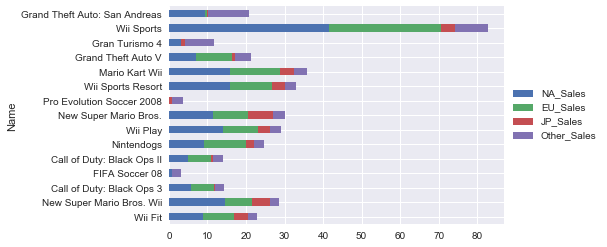

In [66]:
# top15_other をX軸がゲームタイトル、Y軸が地域別の販売数の
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
top15_other.plot.barh(stacked=True, ax=ax)
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

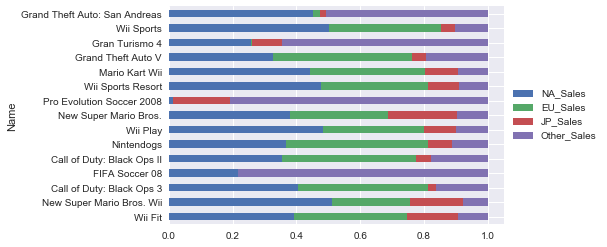

In [67]:
# top15_other をX軸がゲームタイトル、Y軸が地域別販売シェアの
# 積み上げ横棒グラフとしてプロットしてください。
fig, ax = plt.subplots()
(top15_other
 .apply(lambda x : x / top15_other.sum(axis=1))
 .plot.barh(stacked=True, ax=ax))
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

グラフから読み取れることはなんですか？

- Wiiに関連するタイトルが上位を占めている。
- EUでは全く売れていないタイトルも売れている。

#### ジャンルごとの販売数の地域間の相関

ジャンルごとの各地域間の相関係数をヒートマップで確認してみます。

In [68]:
def corr_between_regions(df):
    corr = df.corr()
    names = ['NA', 'EU', 'JP', 'Other']
    result = pd.DataFrame()
    
    for i in range(4):
        for j in range(i + 1, 4):
            result[names[i] + ' - '  + names[j]] = [corr.iloc[i, j]]
            
    return result

In [69]:
corr_by_genre = (game_data
        .groupby('Genre')[SALES]
        .apply(corr_between_regions)
        .reset_index(level=1, drop=True))
corr_by_genre.head()

NA - EU   NA - JP  NA - Other   EU - JP  EU - Other  JP - Other
Genre                                                                      
Action     0.811324  0.253027    0.702575  0.256354    0.574444    0.194505
Adventure  0.778866  0.079872    0.798277  0.060069    0.905788    0.090911
Fighting   0.789932  0.601879    0.664431  0.463263    0.694936    0.378778
Misc       0.787905  0.311423    0.778366  0.542882    0.829368    0.396555
Platform   0.931409  0.855825    0.876973  0.849253    0.940878    0.797224

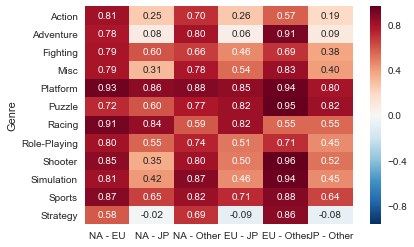

In [70]:
sns.heatmap(corr_by_genre, annot=True, fmt=".2f")

#### ジャンルごとの販売数の推移

ジャンルごとの全世界での販売数を時系列としてプロットします。

In [71]:
genre_year = (game_data.pivot_table('Global_Sales', ['Genre', 'Year'], aggfunc='sum')
              .reset_index())
genre_year.head(20)

Genre  Year  Global_Sales
0      Action  2001         59.39
1      Action  2002         86.75
2      Action  2003         67.93
3      Action  2004         76.26
4      Action  2005         85.66
5      Action  2006         66.58
6      Action  2007        106.50
7      Action  2008        136.39
8      Action  2009        139.36
9      Action  2010        117.64
10     Action  2011        118.87
11     Action  2012        122.01
12     Action  2013        125.22
13     Action  2014         99.02
14     Action  2015         70.70
15  Adventure  2001          9.12
16  Adventure  2002         11.05
17  Adventure  2003          2.14
18  Adventure  2004          8.51
19  Adventure  2005          8.53

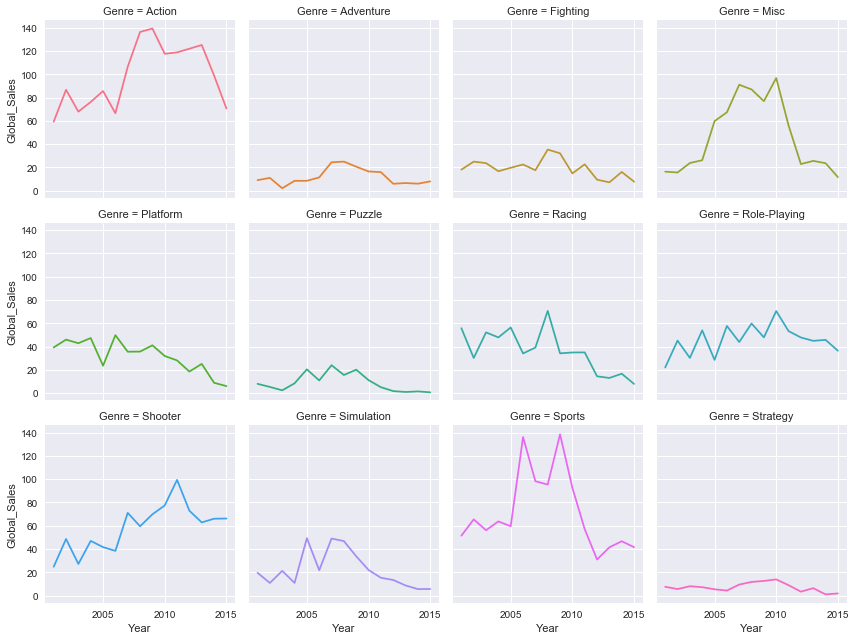

In [72]:
g = sns.FacetGrid(genre_year, col='Genre', hue='Genre', col_wrap=4)
g.map(plt.plot, 'Year', 'Global_Sales');